In [226]:
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.special import logsumexp
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
from numba import njit #,jit,int32,float32,int64,float64,typeof

In [227]:
def simulate_selected_forwards(p0,s_locus,tOn,tOff,N=10000):
    #Generate an allele frequency trajectory forward in time under selection.
    #p0 is the frequency of the allele when selection starts.
    #N is the (constant, diploid) population size.
    #delta is the interval between time steps.
    delta = 1/(2*N)
    traj = [p0]
    time = tOn
    currTime = tOn
    while time > 0:

        #change s depending on pulse timing
        if time > tOff:
            s_t = s_locus
        else:
            s_t = 0
        currFreq = traj[-1]
        if(currFreq > 0 and currFreq < 1):
            nextFreq = np.random.normal(currFreq + delta*2*N*s_t*currFreq*(1-currFreq), np.sqrt(delta) * np.sqrt(currFreq*(1-currFreq)) )
            if nextFreq > 1:
                nextFreq = 1
            if nextFreq < 0:
                nextFreq = 0
            traj.append(nextFreq)
        else:
            traj.append(currFreq)


        time -= delta * (2*N)
        #if time < 1e-8:
        #   print(time,traj[-1])
    return traj

def simulate_neutral_backwards(p0,s_locus,N=10000,stop=None):
    delta = 1/(2*N)
    traj = [p0]
    i = 0
    while traj[-1] != 1 and traj[-1] != 0:
        curr = traj[-1]
        nextFreq = np.random.normal(curr*(1 - delta), np.sqrt(delta) * np.sqrt(curr*(1-curr)) )
        if nextFreq > 1:
            nextFreq = 1
        if nextFreq < 0:
            nextFreq = 0
        traj.append(nextFreq)
        if stop != None and i == stop:
            if traj[:-1] == 0:
                return traj[1:-1]
            else:
                return traj[1:]
        i += 1
    return traj[1:]

In [570]:
@njit('float64(float64[:])',cache=True)
def _logsumexp(a):
    a_max = np.max(a)

    tmp = np.exp(a - a_max)

    s = np.sum(tmp)
    out = np.log(s)

    out += a_max
    return out

@njit('float64(float64[:],float64[:])',cache=True)
def _logsumexpb(a,b):

    a_max = np.max(a)

    tmp = b * np.exp(a - a_max)

    s = np.sum(tmp)
    out = np.log(s)

    out += a_max
    return out

@njit('float64(float64)',cache=True)
def _log_phi(z):
	logphi = -0.5 * np.log(2.0* np.pi) - 0.5 * z * z
	return logphi


@njit('float64[:,:](float64[:,:],float64[:,:])',cache=True)
def _log_prob_mat_mul(A,B):
    # multiplication of probability matrices in log space
    C = np.zeros((A.shape[0],B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            C[i,j] = _logsumexp( A[i,:] + B[:,j])
            if np.isnan(C[i,j]):
                C[i,j] = np.NINF
        ## special sauce...
        C[i,:] -= _logsumexp(C[i,:])
    return C

@njit('float64[:,:](float64[:,:],int64)',cache=True)
def _log_matrix_power(X,n):
    ## find log of exp(X)^n (pointwise exp()!) 

    # use 18 because you are fucked if you want trans
    # for dt > 2^18...
    #print('Calculating matrix powers...')

    maxlog2dt = 18
    assert(np.log(n)/np.log(2) < maxlog2dt)
    assert(X.shape[0] == X.shape[1])
    b = 1
    k = 0
    matrices = np.zeros((X.shape[0],X.shape[1],maxlog2dt))
    matrices[:,:,0] = X
    
    while b < n:
        #print(b,k)
        k += 1
        b += 2**k
        # square the last matrix
        matrices[:,:,k] = _log_prob_mat_mul(matrices[:,:,k-1],
                                           matrices[:,:,k-1])
    leftover = n
    Y = np.NINF * np.ones((X.shape[0],X.shape[0]))
    for i in range(X.shape[0]):
        Y[i,i] = 0
        
    while leftover > 0:
        #print(n-leftover,k)
        if 2**k <= leftover:
            Y = _log_prob_mat_mul(Y,matrices[:,:,k])
            leftover -= 2**k
        k -= 1
        
    return Y

@njit('float64[:](int64,float64,float64,float64[:],float64[:],float64[:],float64[:],int64)',cache=True)
def _log_trans_prob(i,N,s,FREQS,z_bins,z_logcdf,z_logsf,dt):
	# 1-generation transition prob based on Normal distn
	
	p = FREQS[i]
	lf = len(FREQS)
	logP = np.NINF * np.ones(lf)

	if p <= 0.0:
		logP[0] = 0
	elif p >= 1.0:
		logP[lf-1] = 0
		return logP
	else:
		#plo = (FREQS[i]+FREQS[i-1])/2
		#phi = (FREQS[i]+FREQS[i+1])/2
		if s != 0:
			mu = p - s*p*(1.0-p)*dt
            #p - s*p*(1.0-p)/np.tanh(2*N*s*(1-p))*dt
			# mulo = plo - s*plo*(1.0-plo)/np.tanh(2*N*s*(1-plo))*dt
			# muhi = phi - s*phi*(1.0-phi)/np.tanh(2*N*s*(1-phi))*dt
		else:
			mu = p #- p * 1/(4.0*N)*dt
			# mulo = plo - plo * 1/(2.0*N)*dt
			# muhi = phi - phi * 1/(2.0*N)*dt
		sigma = np.sqrt(p*(1.0-p)/(4.0*N)*dt)
		# sigmalo = np.sqrt(plo*(1.0-plo)/(2.0*N)*dt)
		# sigmahi = np.sqrt(phi*(1.0-phi)/(2.0*N)*dt)
                      
		pi0 = np.interp(np.array([(FREQS[0]-mu)/sigma]),z_bins,z_logcdf)[0]
		pi1 = np.interp(np.array([(FREQS[lf-1]-mu)/sigma]),z_bins,z_logsf)[0]

		x = np.array([0.0,pi0,pi1])
		b = np.array([1.0,-1.0,-1.0])
		middleNorm = _logsumexpb(x,b)
        
		# x = np.array([0.0,pi0lo,pi1lo,0.0,pi0hi,pi1hi])
		# b = np.array([0.5,-0.5,-0.5,0.5,-0.5,-0.5])
		# middleNorm = _logsumexpb(x,b)

		middleP = np.zeros(lf-2)
		for j in range(1,lf-1):
			if j == 1:
				mlo = FREQS[0]
			else:
				mlo = np.mean(np.array([FREQS[j],FREQS[j-1]]))
			if j == lf-2:
				mhi = FREQS[j+1]
			else:
				mhi = np.mean(np.array([FREQS[j],FREQS[j+1]]))
    
			l1 = np.interp(np.array([(mlo-mu)/sigma]),z_bins,z_logcdf)[0]
			l2 = np.interp(np.array([(mhi-mu)/sigma]),z_bins,z_logcdf)[0]
			middleP[j-1] = _logsumexpb(np.array([l1,l2]),np.array([-1.0,1.0]))                    


		logP[0] = pi0
		logP[1:lf-1] = middleP
		logP[lf-1] = pi1

	return logP

@njit('float64[:,:](float64,float64,float64[:],float64[:],float64[:],float64[:],int64)',cache=True)
def _nstep_log_trans_prob(N,s,FREQS,z_bins,z_logcdf,z_logsf,dt):
	lf = len(FREQS)
	p1 = np.zeros((lf,lf))

	# load rows into p1
	for i in range(lf):
		row = _log_trans_prob(i,N,s,FREQS,z_bins,z_logcdf,z_logsf,1)
		p1[i,:] = row

	# exponentiate matrix
	pn = _log_matrix_power(p1,int(dt))
	return pn

@njit('float64(float64[:],float64)')
def _genotype_likelihood_emission(ancGLs,p):
	logGenoFreqs = np.array([2*np.log(1-p),np.log(2) + np.log(p) + np.log(1-p),2*np.log(p)])
	emission = _logsumexp(logGenoFreqs + ancGLs)
	if np.isnan(emission):
		emission = -np.inf
	return emission

@njit('float64(float64[:],int64,float64[:],float64,float64,float64,int64)',cache=True)
def _log_coal_density(times,n,epoch,xi,Ni,N0,anc=0):
    if n == 1:
        # this flag indicates to ignore coalescence
        return 0.0
    
    logp = 0
    prevt = epoch[0]
    if anc == 1:
        xi = 1.0-xi
    k=n
    for i,t in enumerate(times):
        k = n-i
        kchoose2 = k*(k-1)/4
        dLambda = 1/(xi*Ni)*(t-prevt)
        logpk = - np.log(xi) - kchoose2 * dLambda
        logp += logpk
        
        prevt = t
        k -= 1
    kchoose2 = k*(k-1)/4
    logPk = - kchoose2 * 1/(xi*Ni)*(epoch[1]-prevt)

    logp += logPk
    return logp

@njit('float64(float64[:,:],float64[:],float64[:])',cache=True)
def proposal_density(times,epochs,N):
        '''
    Moves backward in time from present to past
    '''
    T = len(epochs)-1
    logl = 0.
    cumGens = 0
    
    combinedTimes = np.sort(np.concatenate((times[0,:],times[1,:])))
    n = np.sum(combinedTimes>=0)+2
    nRemaining = n
    N0 = N[0]
    for tb in range(0,T):
        dt = epochs[tb+1]-epochs[tb]
        Nt = N[tb]
        epoch = np.array([cumGens,cumGens+dt])
        
        #grab coal times during epoch
        # calculate coal emission probs

        Coals = np.copy(combinedTimes)
        Coals = Coals[Coals > cumGens]
        Coals = Coals[Coals <= cumGens+dt]
        numCoals = len(Coals)
      
        logl += _log_coal_density(Coals,nRemaining,epoch,1.0,Nt,N0,anc=0)
        nRemaining -= len(Coals)
        
        cumGens += dt
    return logl


@njit('float64[:,:](float64[:],float64[:,:],float64[:],float64[:],float64[:],float64[:],float64[:],float64[:],float64[:,:],int64)',cache=True)
def forward_algorithm(sel,times,epochs,N,freqs,z_bins,z_logcdf,z_logsf,ancientGLs,noCoals=1):

    '''
    Moves forward in time from past to present
    '''
    
    # neutral SFS prior on initial frequency
    lf = len(freqs)

    
    alpha = np.zeros(lf)
    alpha -= _logsumexp(alpha)
    
    T = len(epochs)-1
    alphaMat = np.zeros((T+1,lf))
    alphaMat[-1,:] = alpha

    prevNt = -1
    prevst = -1
    prevdt = -1
    prevNumDerCoals = -1
    prevNumAncCoals = -1
    
    
    cumGens = epochs[-1]
    
    nDer = np.sum(times[0,:]>=0)+1
    nDerRemaining = nDer - np.sum(np.logical_and(times[0,:]>=0, times[0,:]<=epochs[-1]))
    nAnc = np.sum(times[1,:]>=0)+1
    nAncRemaining = nAnc - np.sum(np.logical_and(times[1,:]>=0, times[1,:]<=epochs[-1]))
    coalEmissions = np.zeros(lf)
    N0 = N[0]
    for tb in range(T-1,0,-1):
        dt = -epochs[tb]+epochs[tb+1]
        epoch = np.array([cumGens - dt,cumGens])
        Nt = N[tb]
        
        st = sel[tb]
        prevAlpha = np.copy(alpha)
        
        if prevNt != Nt or prevst != st or prevdt != dt:
            #print(Nt,st,dt)
            currTrans = _nstep_log_trans_prob(Nt,st,freqs,z_bins,z_logcdf,z_logsf,dt)
        
        #grab ancient GL rows
        ancientGLrows = ancientGLs[np.logical_and(ancientGLs[:,0] <= cumGens, ancientGLs[:,0] > cumGens - dt)]
        
        # calculate ancient GL emission probs
        glEmissions = np.zeros(lf)
        
        for j in range(lf):
            for iac in range(ancientGLrows.shape[0]):
                glEmissions[j] += _genotype_likelihood_emission(ancientGLrows[iac,1:],freqs[j])
                
        # calculate coal emission probs
        
        if noCoals:
            coalEmissions = np.zeros(lf)
        else:
            derCoals = np.copy(times[0,:])
            derCoals = derCoals[derCoals <= cumGens]
            derCoals = derCoals[derCoals > cumGens-dt]
            numDerCoals = len(derCoals)
            ancCoals = np.copy(times[1,:])
            ancCoals = ancCoals[ancCoals <= cumGens]
            ancCoals = ancCoals[ancCoals > cumGens-dt]
            numAncCoals = len(ancCoals)
            nDerRemaining += len(derCoals)
            nAncRemaining += len(ancCoals)
            #print(epoch,derCoals,nDerRemaining,nAncRemaining)
            #if prevNt != Nt or prevst != st or prevdt != dt or numDerCoals != 0 or prevNumAncCoals != 0 or numAncCoals != 0 or prevNumAncCoals != 0:
                #print(cumGens)
            for j in range(lf):
                    coalEmissions[j] = _log_coal_density(derCoals,nDerRemaining,epoch,freqs[j],Nt,N0,anc=0)
                    coalEmissions[j] += _log_coal_density(ancCoals,nAncRemaining,epoch,freqs[j],Nt,N0,anc=1)

        
        #print(tb,ancientGLrows)
        for i in range(lf):
            alpha[i] = _logsumexp(prevAlpha + currTrans[i,:] + glEmissions + coalEmissions) 
            if np.isnan(alpha[i]):
                alpha[i] = -np.inf
        
        prevNt = Nt
        prevdt = dt
        prevst = st
        prevNumAncCoals = numAncCoals
        prevNumDerCoals = numDerCoals
        cumGens -= dt
        alphaMat[tb,:] = alpha
    return alphaMat
    
@njit('float64[:,:](float64[:],float64[:,:],float64[:],float64[:],float64[:],float64[:],float64[:],float64[:],float64[:,:],int64,float64)',cache=True)
def backward_algorithm(sel,times,epochs,N,freqs,z_bins,z_logcdf,z_logsf,ancientGLs,noCoals=1,currFreq=-1):

    '''
    Moves backward in time from present to past
    '''
    
    lf = len(freqs)
    alpha = np.zeros(lf)
    
    if currFreq != -1:
        nsamp = 1000
        for i in range(lf):
            k = int(currFreq*nsamp)
            alpha[i] = -np.sum(np.log(np.arange(2,k+1)))
            alpha[i] += np.sum(np.log(np.arange(2,nsamp-k+1)))
            alpha[i] += k*np.log(freqs[i]) + (nsamp-k)*np.log(1-freqs[i])
            
    T = len(epochs)-1
    alphaMat = np.zeros((T+1,lf))
    alphaMat[0,:] = alpha
    
    prevNt = -1
    prevst = -1
    prevdt = -1
    prevNumDerCoals = -1
    prevNumAncCoals = -1
    
    cumGens = 0
    
    nDer = np.sum(times[0,:]>=0)+1
    nDerRemaining = nDer
    nAnc = np.sum(times[1,:]>=0)+1
    nAncRemaining = nAnc
    N0 = N[0]
    coalEmissions = np.zeros(lf)
    for tb in range(0,T):
        dt = epochs[tb+1]-epochs[tb]
        Nt = N[tb]
        epoch = np.array([cumGens,cumGens+dt])
        st = sel[tb]
        prevAlpha = np.copy(alpha)
        
        if prevNt != Nt or prevst != st or prevdt != dt:
            #print(Nt,st,dt)
            currTrans = _nstep_log_trans_prob(Nt,st,freqs,z_bins,z_logcdf,z_logsf,dt)
        
        #grab ancient GL rows
        ancientGLrows = ancientGLs[ancientGLs[:,0] > cumGens]
        ancientGLrows = ancientGLrows[ancientGLrows[:,0] <= cumGens + dt]

        glEmissions = np.zeros(lf)
        for j in range(lf):
            for iac in range(ancientGLrows.shape[0]):
                glEmissions[j] += _genotype_likelihood_emission(ancientGLrows[iac,1:],freqs[j])
        
        #grab coal times during epoch
        # calculate coal emission probs
        if noCoals:
            coalEmissions = np.zeros(lf)
            numAncCoals = -1
            numDerCoals = -1
        else:            
            derCoals = np.copy(times[0,:])
            derCoals = derCoals[derCoals > cumGens]
            derCoals = derCoals[derCoals <= cumGens+dt]
            numDerCoals = len(derCoals)
            ancCoals = np.copy(times[1,:])
            ancCoals = ancCoals[ancCoals > cumGens]
            ancCoals = ancCoals[ancCoals <= cumGens+dt]
            numAncCoals = len(ancCoals)
            #print(epoch,derCoals,nDerRemaining,nAncRemaining)
            #if prevNt != Nt or prevst != st or prevdt != dt or numDerCoals != 0 or prevNumAncCoals != 0 or numAncCoals != 0 or prevNumAncCoals != 0:
            for j in range(lf):
                    coalEmissions[j] = _log_coal_density(derCoals,nDerRemaining,epoch,freqs[j],Nt,N0,anc=0)
                    coalEmissions[j] += _log_coal_density(ancCoals,nAncRemaining,epoch,freqs[j],Nt,N0,anc=1)
            nDerRemaining -= len(derCoals)
            nAncRemaining -= len(ancCoals)

        
        
        #print(tb,ancientGLrows)
        for i in range(lf):
            alpha[i] = _logsumexp(prevAlpha + currTrans[:,i] ) + glEmissions[i] + coalEmissions[i]
            if np.isnan(alpha[i]):
                alpha[i] = -np.inf
        
        prevNt = Nt
        prevdt = dt
        prevst = st
        prevNumDerCoals = numDerCoals
        prevNumAncCoals = numAncCoals
        
        cumGens += dt
        alphaMat[tb,:] = alpha
    return alphaMat


In [608]:
def simulate_traj(p0,s,tOn,tOff,Ne=1*10**4,gens=500):
    # simulating trajectory with a pulse of selection
    # also sample genotype likelihoods

    traj = simulate_selected_forwards(p0,s,tOn,tOff,N=Ne)
    traj = traj[::-1]
    traj += simulate_neutral_backwards(p0,0,Ne)

    
    return traj

def simulate_gls_from_traj(epochs,traj,gens,nsamp=1000):
    # simulating trajectory with a pulse of selection
    # also sample genotype likelihoods
    
    # simulating sampling ancient GLs
    
    times = np.random.uniform(0,gens,size=nsamp)
    ancGLs = np.zeros((len(times),4))
    ancGLs[:,1:] = -np.inf
    genos = []
    for i,t in enumerate(np.sort(times)):
        geno = np.random.binomial(2,traj[np.digitize(t,epochs)+1])
        genos.append(geno)
        ancGLs[i,geno+1] = 0.0
        ancGLs[i,0] = t
    
    return ancGLs, genos

def initialize_pulse_model(s,tOn,tOff,Ne=1*10**4,gens=500,tSkip=1):  
    # setting up HMM model
    epochs = np.arange(0,gens+1,tSkip,dtype=float)
    sel = np.zeros(len(epochs)-1)
    sel[(epochs[:-1] < tOn) & (epochs[:-1] >= tOff)] = s

    N = Ne * np.ones(gens)

    a=1
    b=a
    c = 1/(2*Ne)
    df = 150
    freqs = stats.beta.ppf(np.linspace(c,1-c,df),a,b)
    
    return sel,epochs,N,freqs

def initialize_epoch_model(S,timeBins,Ne=1*10**4,gens=500):  
    # setting up HMM model
    epochs = np.arange(0,gens,dtype=float)
    sel = S[np.digitize(epochs,timeBins)-1]

    N = Ne * np.ones(gens)

    a=1
    b=a
    c = 1/(2*Ne)
    df = 120
    freqs = stats.beta.ppf(np.linspace(c,1-c,df),a,b)
    
    return sel,epochs,N,freqs

def load_normal_tables():
    # read in global Phi(z) lookups
    z_bins = np.genfromtxt('z_bins.txt')
    z_logcdf = np.genfromtxt('z_logcdf.txt')
    z_logsf = np.genfromtxt('z_logsf.txt')
    return z_bins,z_logcdf,z_logsf

def plot_trajs(trueTraj,alphaMat,betaMat,freqs,gens=500,tSkip=10):
    postFreq = (alphaMat[1:,:] + betaMat[:-1,:]).transpose()
    postFreq -= logsumexp(postFreq,axis=0)
    plt.pcolormesh(range(0,gens,tSkip),freqs,np.exp(postFreq[:,:]),cmap='plasma_r')
    plt.colorbar()
    plt.plot(trueTraj,label='true')

    #plt.scatter(range(0,gens,tSkip),1/2*np.array(genos),alpha=0.2,c='k',label='ancient genotypes')
    plt.ylabel('freq')
    plt.xlabel('time before present')
    plt.legend()    
    return

def plot_genos(times,genos):
    plt.scatter(times,genos,c='k',alpha=0.1)

    plt.ylabel('freq')
    plt.xlabel('time before present')
    return



# Quick demo (no coalescences)

The cell below demonstrates (1) simulation of the trajectory (and genotypes) and (2) inference of the trajectory, conditional on some model of selection (here, a 'pulse' model where s != 0 for some time period defined by tOn, tOff.

(0, 500, 0, 1)

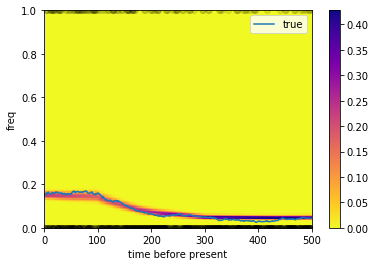

In [237]:

### 1 ### Simulation

sTrue = 0.01
tOnTrue = 300
tOffTrue = 100
p0 = 0.05
Ne = 1*10**4
gens = 500
tSkip = 1

traj = simulate_traj(p0,sTrue,tOnTrue,tOffTrue,Ne=Ne,gens=gens)
currentFreq = traj[0]

##########
### 2 ### Inference (fixing the values of s/tOn/tOff)

sNominal = 0.01
tOnNominal = 300
tOffNominal = 100

sel,epochs,N,freqs = initialize_pulse_model(sNominal,tOnNominal,tOffNominal,Ne=Ne,gens=gens,tSkip=tSkip)
ancGLs, genos = simulate_gls_from_traj(epochs,traj,gens,nsamp=1000)

z_bins,z_logcdf,z_logsf = load_normal_tables()

times = -1.0*np.ones((2,1))

alphaMat = forward_algorithm(sel,times,epochs,N,freqs,z_bins,z_logcdf,z_logsf,ancGLs,noCoals=1)
betaMat = backward_algorithm(sel,times,epochs,N,freqs,z_bins,z_logcdf,z_logsf,ancGLs,noCoals=1,currFreq=currentFreq)

plot_trajs(traj,alphaMat,betaMat,freqs,gens=500,tSkip=tSkip)
plot_genos(ancGLs[:,0],genos)
plt.axis((0,gens,0,1))
##########


# Quick demo (*with* coalescences)

## Example using in-notebook simulations

In [653]:
np.savetxt('trait_example/ld_53/ancientSamps.txt',ancGLs,delimiter='\t')

(0, 200, 0, 1)

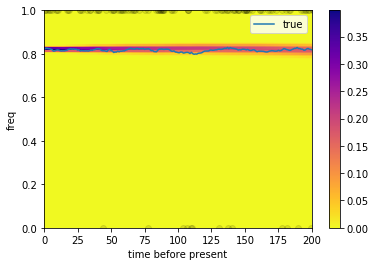

In [652]:
def simulate_coals(epochs,traj,nDer,nAnc,N,stop=500):
    derTimes = []
    ancTimes = []
    cDer = nDer
    cAnc = nAnc
    epoch = 0
    i = 0
    while epoch < stop:
        i += 1
        epoch = epochs[i]
        dt = epochs[i] - epochs[i-1]
        tDer = 0
        while tDer < dt and cDer > 1:
            Kd = cDer*(cDer-1)/4/N[i-1]
            Td = np.random.exponential(traj[i-1]/Kd)
            tDer += Td
            if tDer < dt:
                #print(epoch+tDer,cDer)
                derTimes.append(epochs[i-1]+tDer)
                cDer -= 1
        tAnc = 0
        while tAnc < dt and cAnc > 1:    
            Ka = cAnc*(cAnc-1)/4/N[i-1]
            Ta = np.random.exponential((1-traj[i])/Ka)
            tAnc += Ta
            if tAnc < dt:
                ancTimes.append(epochs[i-1]+tAnc)
                cAnc -= 1
    derTimes = np.array(derTimes)
    ancTimes = np.array(ancTimes)
    return derTimes,ancTimes
        
stop=1000
epochs = np.arange(0.0,stop)
t = np.linspace(0,stop,stop)

pwd = 'trait_example/ld_53'
traj = np.genfromtxt('%s/mssel.traj'%(pwd),skip_header=3)[:,1]
nDer = 2000
nAnc = 1000
N = 10000*np.ones(stop)

derTimes,ancTimes = simulate_coals(epochs,traj,nDer,nAnc,N,stop=stop-1)

noCoals = 0

times = -1.0*np.ones((2,np.max([len(derTimes),len(ancTimes)])))
times[0,:len(derTimes)] = 1*derTimes
times[1,:len(ancTimes)] = 1*ancTimes

currentFreq = traj[0]
sNominal = -0.00
tOnNominal = 50
tOffNominal = 0
gens = stop
Ne=1*10**4
tSkip=1


ancGLs, genos = simulate_gls_from_traj(epochs,traj,300,nsamp=500)
#ancGLs = np.zeros((0,0))
sel,epochs,N,freqs = initialize_pulse_model(sNominal,tOnNominal,tOffNominal,Ne=Ne,gens=gens,tSkip=tSkip)
z_bins,z_logcdf,z_logsf = load_normal_tables()

alphaMat = forward_algorithm(sel,times,epochs,N,freqs,z_bins,z_logcdf,z_logsf,ancGLs,noCoals=noCoals)
betaMat = backward_algorithm(sel,times,epochs,N,freqs,z_bins,z_logcdf,z_logsf,ancGLs,noCoals=noCoals,currFreq=-1)

plot_trajs(traj,alphaMat,betaMat,freqs,gens=gens,tSkip=tSkip)
plot_genos(ancGLs[:,0],genos)
plt.axis((0,200,0,1))


## Example using *mssel* simulations

In [649]:
import pandas as pd
df = pd.read_csv('trait_example/metadata.tsv',index_col=0,sep='\t')
df[df.s==0]

,variant,derived_allele,minor_allele,minor_AF,p0,pcurr,ntot,nder,s,beta@Ever/Never Smoked,...,pval@Height,pval@Infant Head Circumference,pval@Birth Length,pval@Birth Weight,pval@Autism Spectrum,pval@Years of Education,pval@Anorexia,pval@Depression,pval@Bipolar,pval@Schizophrenia
ld_0,1:500000:A:T,T,T,0.073892,0.07170,0.073892,400,26,0.0,0.000000,...,7.589609e-01,4.886069e-56,9.324185e-01,3.584854e-01,2.782775e-01,0.977255,9.998693e-01,8.883464e-01,3.178077e-01,0.370938
ld_2,1:500000:A:T,T,T,0.480376,0.45475,0.480376,400,211,0.0,0.000000,...,1.002998e-01,2.283249e-01,2.081360e-01,7.929630e-01,9.051880e-01,0.017675,2.326409e-01,8.386134e-145,6.698495e-01,0.884162
ld_7,1:500000:A:T,T,T,0.122804,0.10465,0.122804,400,48,0.0,0.000000,...,1.079425e-02,7.608452e-02,6.708893e-02,8.852863e-01,0.000000e+00,0.764844,4.486611e-01,4.488869e-02,9.906798e-01,0.811162
ld_9,1:500000:A:T,T,T,0.091902,0.11845,0.091902,400,33,0.0,0.000000,...,4.472988e-01,7.002864e-01,8.648133e-01,4.702715e-01,5.642018e-01,0.553164,5.437888e-01,4.018516e-01,5.634871e-01,0.042162
ld_14,1:500000:A:T,T,A,0.358409,0.61960,0.641591,400,242,0.0,0.000000,...,6.550119e-74,2.084119e-01,9.782011e-01,9.828023e-01,9.031252e-01,0.370204,5.468787e-01,9.692831e-01,7.552365e-01,0.560152
ld_16,1:500000:A:T,T,T,0.232377,0.26530,0.232377,400,102,0.0,0.000000,...,6.155186e-01,9.573778e-01,8.368583e-153,1.024659e-01,8.623101e-01,0.818876,9.400297e-01,8.719918e-02,2.310058e-01,0.165563
ld_18,1:500000:A:T,T,T,0.454135,0.43100,0.454135,400,190,0.0,0.000000,...,6.844330e-02,5.256873e-01,5.266222e-01,3.242628e-01,9.734231e-01,0.370413,5.919457e-01,9.307649e-01,9.869202e-01,0.911077
ld_20,1:500000:A:T,T,T,0.169467,0.16440,0.169467,400,67,0.0,-0.066674,...,1.161847e-01,3.416836e-01,1.305327e-01,3.038842e-02,1.574601e-01,0.857324,6.219050e-01,4.401804e-01,7.604659e-01,0.467473
ld_26,1:500000:A:T,T,T,0.111529,0.11065,0.111529,400,43,0.0,0.000000,...,3.324654e-02,8.739860e-01,3.991804e-01,3.488524e-01,7.311832e-01,0.470969,2.325591e-01,3.348584e-01,6.239628e-01,0.929395
ld_31,1:500000:A:T,T,A,0.232047,0.73680,0.767953,400,312,0.0,0.000000,...,6.124848e-01,9.225697e-02,2.966051e-01,6.670384e-01,1.177272e-01,0.437509,6.344168e-02,8.738236e-01,5.699616e-01,0.612549


(0, 1000, 0, 1)

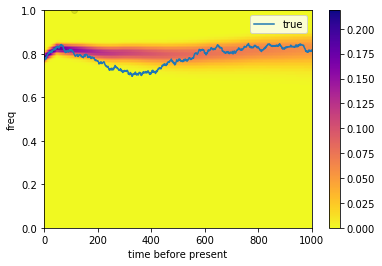

In [591]:


noCoals = 0

if not noCoals:
    derTimes = np.load('%s/mssel.der.npy'%(pwd))[0,:]
    ancTimes = np.load('%s/mssel.anc.npy'%(pwd))[0,:]
    times = -1.0*np.ones((2,np.max([len(derTimes),len(ancTimes)])))
    times[0,:len(derTimes)] = 1*derTimes
    times[1,:len(ancTimes)] = 1*ancTimes

currentFreq = traj[0]
sNominal = -0.01
tOnNominal = 50
tOffNominal = 0
gens = 1000
Ne=1*10**4
tSkip=1


ancGLs, genos = simulate_gls_from_traj(epochs,traj,500,nsamp=1)
#ancGLs = np.zeros((0,0))
sel,epochs,N,freqs = initialize_pulse_model(sNominal,tOnNominal,tOffNominal,Ne=Ne,gens=gens,tSkip=tSkip)
z_bins,z_logcdf,z_logsf = load_normal_tables()

alphaMat = forward_algorithm(sel,times,epochs,N,freqs,z_bins,z_logcdf,z_logsf,ancGLs,noCoals=noCoals)
betaMat = backward_algorithm(sel,times,epochs,N,freqs,z_bins,z_logcdf,z_logsf,ancGLs,noCoals=noCoals,currFreq=currentFreq)

plot_trajs(traj,alphaMat,betaMat,freqs,gens=gens,tSkip=tSkip)
plot_genos(ancGLs[:,0],genos)
plt.axis((0,1000,0,1))


# Optimization over S

In fact we never know the selection S, so here I'm showing how to estimate S (a vector, signifying a selection coefficient changing over time). I use Nelder Mead to optimize. No particular reason why I choose that method, but it seems to work fairly well -- it can optimize over 5 time periods in a couple minutes. 

In [131]:
def likelihood_wrapper(theta,timeBins,N,freqs,currentFreq,z_bins,z_logcdf,z_logsf,ancGLs,gens):
    S = theta
    
    if np.any(np.abs(S) > 0.1):
        return np.inf

    epochs = np.arange(0,gens+1,dtype=float)
    sel = S[np.digitize(epochs,timeBins,right=False)-1]
    alphaMat = forward_algorithm(sel,epochs,N,freqs,z_bins,z_logcdf,z_logsf,ancGLs)
    betaMat = backward_algorithm(sel,epochs,N,freqs,currentFreq,z_bins,z_logcdf,z_logsf,ancGLs)
    logl = -logsumexp(alphaMat[1,:]+betaMat[1,:])
    print(logl,S)
    return logl


S0 = 1e-3 * np.ones(6)
timeBins = np.linspace(0,500,6)

Simplex = np.zeros((7,6))
for i in range(Simplex.shape[0]-1):
    Simplex[i,:] = -0.01
    Simplex[i,i] = 0.01
Simplex[-1,:] = 0.01
    
#for tup in product(*[[-1,1] for i in range(3)]):
    

args = (timeBins,N,freqs,currentFreq,z_bins,z_logcdf,z_logsf,ancGLs,gens)
minimize(likelihood_wrapper,
         S0,
         args=args,
         options={'fatol':1e-3,'initial_simplex':Simplex},
        method='Nelder-Mead')

-2656.318864829 [ 0.01 -0.01 -0.01 -0.01 -0.01 -0.01]
-2660.2628948783613 [-0.01  0.01 -0.01 -0.01 -0.01 -0.01]
-2648.5196252513324 [-0.01 -0.01  0.01 -0.01 -0.01 -0.01]
-2632.6696659165154 [-0.01 -0.01 -0.01  0.01 -0.01 -0.01]
-2623.648957605895 [-0.01 -0.01 -0.01 -0.01  0.01 -0.01]
-2619.443172091064 [-0.01 -0.01 -0.01 -0.01 -0.01  0.01]
-2682.0674470896665 [0.01 0.01 0.01 0.01 0.01 0.01]
-2677.695686992917 [ 0.00333333  0.00333333  0.00333333  0.00333333  0.00333333 -0.02333333]
-2680.810748642891 [ 0.00777778  0.00777778  0.00777778  0.00777778 -0.01888889 -0.00777778]
-2677.1382745370115 [ 0.0137037   0.0137037   0.0137037  -0.01296296 -0.00185185 -0.00703704]
-2663.692859703413 [ 0.02160494  0.02160494 -0.00506173  0.00604938  0.0008642  -0.00604938]
-2668.16714922144 [ 0.00547325  0.03213992  0.01658436  0.01139918  0.0044856  -0.00473251]
-2646.2509303012234 [ 0.030631    0.01951989  0.02544582  0.01853224  0.00931413 -0.00297668]
-2678.297651571609 [ 0.00015775  0.01237997 -0.

 final_simplex: (array([[0.00304832, 0.00900043, 0.01749984, 0.00576116, 0.01811614,
        0.00190135],
       [0.00304197, 0.00900986, 0.01747603, 0.00577528, 0.01818275,
        0.00194208],
       [0.00306083, 0.00899438, 0.01750768, 0.00571305, 0.01819084,
        0.0019058 ],
       [0.00304113, 0.00900985, 0.0174928 , 0.00567501, 0.01816826,
        0.00188633],
       [0.0030573 , 0.00900752, 0.01749557, 0.00571658, 0.01810599,
        0.00185828],
       [0.00305735, 0.0090148 , 0.01748621, 0.00574937, 0.01812383,
        0.00191251],
       [0.00304233, 0.00902649, 0.01749687, 0.00576101, 0.01812147,
        0.00192139]]), array([-2684.30356893, -2684.3035659 , -2684.30356581, -2684.30356529,
       -2684.30356447, -2684.30356428, -2684.30356122]))
           fun: -2684.3035689253793
       message: 'Optimization terminated successfully.'
          nfev: 183
           nit: 109
        status: 0
       success: True
             x: array([0.00304832, 0.00900043, 0.01749984, 

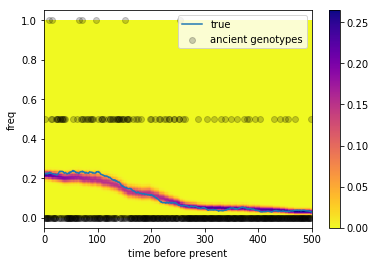

In [129]:
S = np.array([0.00292551, 0.00917736, 0.01740725, 0.00621393, 0.01770234, 0.00220417])
timeBins = np.linspace(0,500,6)
epochs = np.arange(0,gens+1,dtype=float)
sel = S[np.digitize(epochs,timeBins)-1]

alphaMat = forward_algorithm(sel,epochs,N,freqs,z_bins,z_logcdf,z_logsf,ancGLs)
betaMat = backward_algorithm(sel,epochs,N,freqs,currentFreq,z_bins,z_logcdf,z_logsf,ancGLs)

plot_trajs(traj,alphaMat,betaMat,freqs,genos,gens=500,tSkip=tSkip)
    

Text(0.5, 0, 'Selection coeff')

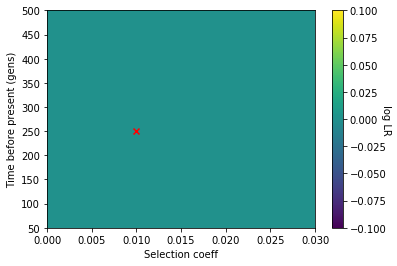

In [43]:
## grid search

Ss = np.linspace(0,0.03,10)
Ts = [50,100,150,200,250,300,350,400,450,500]

Ls = np.zeros((len(Ss),len(Ts)))

'''
for i,S in enumerate(Ss):
    for j,tOn in enumerate(Ts):
        sel = np.zeros(gens)
        sel[epochs[:-1] < tOn] = S
        alphaMat = forward_algorithm(sel,epochs,N,freqs,z_bins,z_logcdf,z_logsf,ancGLs)
        L = _logsumexp(alphaMat[1,:] + stats.binom.logpmf(nCurr,n,freqs))
        Ls[i,j] = L
        print(S,tOn,L)
'''

plt.pcolormesh(Ss,Ts,Ls-Ls[0,0],shading='gouraud')
cbar = plt.colorbar()
cbar.set_label('log LR', rotation=270)
#plt.xticks([0.0,0.01,0.02,0.03,0.04,0.05])
plt.scatter(0.01,250,marker='x',color='r')
plt.ylabel('Time before present (gens)')
plt.xlabel('Selection coeff')

In [624]:
a = np.zeros((4,0))